In [93]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System, OptimizerType, plot_loss_df,  set_seeds, SamplingMethod
torch.set_default_dtype(torch.float64) # Set default data type for torch tensors to double precision

In [94]:
latex_var_mapping = {
    r"\eta": "eta",
    
    r"q": "q",
    r"\kappa": "kappa",
    r"\sigma^q": "sigmaq",
    
    r"\iota": "iota",
    r"\chi": "chi",
    
    r"\rho^e": "rhoe",
    r"\rho^h": "rhoh",
    r"\delta": "delta",
    r"a^e": "ae",
    r"a^h": "ah",
    r"\sigma": "sigma",
    r"\phi": "phi",
    r"\alpha": "alpha",
    r"\ell": "ell",
}

In [95]:
params = {
    "rhoe": 0.06,
    "rhoh": 0.04,
    "delta": 0.05,
    "ae": 0.11,
    "ah": 0.03,
    "sigma": 0.10,
    "phi": 10,
    "alpha": 0.8,
    "ell": 0.55
}

globals().update(params) # unpack parameters

## Neural Network

$\chi<\kappa$ indicates that experts issue outside equity. The lower $\kappa$ is, the more the outside equity issued.

Key: when experts' risk premium is higher than households' risk premium, then it is always optimal for expert to issue outside equity. This can be seen from the below asset pricing equation of expert.
$$
\frac{a^e-\iota_t}{q_t}+ \frac{d(q_tk_t)}{q_tk_t}=r_t+\left[\varsigma_t^e\chi_t^e / \kappa_t^e+\varsigma_t^h\left(1-\chi_t^e / \kappa_t^e\right)\right]\left(\sigma+\sigma_t^q\right) 
$$
$$
\varsigma_t^e - \varsigma_t^h = \frac{\chi_t - \eta_t}{\eta_t(1-\eta_t)}
$$

Issuing outside equity will lower $\chi_t$. As long as $\varsigma_t^e > \varsigma_t^h$, expert tends to lower $\chi_t$ to make higher return. Therefore, the key is to check the relationship between $\alpha\kappa$ and $\eta$.

Except for the leverage constrained region, there are three regions. 
1. When $\eta$ is close enough to 0, then the experts' risk premia are so much higher than those of households that $\kappa<1$, ie, households hold capital, and Eq.3 holds. In this region experts issue the maximal allowed equity share to households, so $\chi=\alpha\kappa$, since the households’ risk premia are lower. 
2. In the middle region, $\kappa=1$, ie, only experts hold capital, but the experts’ risk premia are still higher than those of households ($\alpha\kappa = \alpha>\eta$), so $\chi=\alpha\kappa$. 
3. Finally, when $\eta\geq\alpha$, the capital is allocated efficiently to experts (ie, $\kappa=1$) and risk can be shared perfectly between households and experts by setting $\chi = \eta\kappa=\eta$. For $\eta>\alpha$, $\sigma^q=0$, $\kappa=1$, $q=\frac{\phi a^e + 1}{\phi(\eta\rho^e+(1-\eta)\rho^h)+1}$ 

The below algorithm solve the model separately in the above three regions plus (4) the leverage constrained region. 

#### Region 1: Unconstrained region

In the unconstrained regime $\kappa<1$, we need to solve the below ODE system:
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\chi - \eta) (\sigma + \sigma^q) - \sigma^q q = 0\\
&a^e - a^h - \alpha \frac{q (\chi - \eta)}{(1 - \eta) \eta} (\sigma + \sigma^q)^2 = 0
\end{cases}
$$
where $\eta$ is the state variable, $(q, \kappa, \sigma^q)$ are functions of $\eta$. We parameterize by Neural Network (NN) $(q, \kappa, \sigma^q)$ where $\eta$ is the input. 

Specifically, we use state variable $\eta \in (0,\alpha]$, and add $\sigma^q(\alpha)=0$ as the right boundary condition.

In [96]:
batch_size = 1000
set_seeds(0)
pde_model_unconstrain = PDEModel(name = "Contrasting_Financial_Frictions", 
                                 latex_var_mapping=latex_var_mapping, 
                                 config={"sampling_method": SamplingMethod.FixedGrid, 
                                         "batch_size": batch_size,
                                         "num_epochs": 20000,
                                         "optimizer_type": OptimizerType.Adam})
pde_model_unconstrain.set_state(["eta"], {"eta": [0.001, alpha]})  
pde_model_unconstrain.add_endogs(names = ["q", "kappa", "sigmaq"], 
                                 configs={"q": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "kappa": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "sigmaq": {"positive": False, "activation_type": ActivationType.SiLU}})
pde_model_unconstrain.add_params(params)
pde_model_unconstrain.add_endog_condition(name="q", 
                              lhs = "q(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "(phi*ah + 1)/(phi*rhoh + 1)",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="q_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="kappa",
                              lhs = "kappa(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="kappa_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="sigmaq",
                              lhs = "sigmaq(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="sigmaq_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="sigmaq",
                              lhs = "sigmaq(SV)",
                              lhs_state = {"SV": torch.tensor([[alpha]])},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="sigmaq_max",
                              weight=batch_size/10)

pde_model_unconstrain.add_endog_equation(r"$\kappa*a^e + (1 - \kappa)*a^h - \iota - q * ( \eta *\rho^e + (1 - \eta) *\rho^h ) = 0$", weight=batch_size) 
pde_model_unconstrain.add_endog_equation(r"$\frac{\partial q}{\partial \eta}* (\chi - \eta) *(\sigma + \sigma^q) - \sigma^q *q = 0$", weight=batch_size)
pde_model_unconstrain.add_endog_equation(r"$(a^e - a^h - \alpha*\frac{q* (\chi - \eta)}{(1 - \eta) *\eta} * (\sigma + \sigma^q)^2)= 0$", weight=batch_size*2)

pde_model_unconstrain.add_equation(r"$\iota = \frac{1}{\phi} * (q - 1)$")
pde_model_unconstrain.add_equation(r"$\chi = \alpha*\kappa$")
pde_model_unconstrain.train_model("./models/05", "05.pt", True)
pde_model_unconstrain.load_model(torch.load("./models/05/05.pt"))
pde_model_unconstrain.eval_model(True)

====================================Training====================================


Total loss: 0.0048: 100%|██████████| 20000/20000 [08:59<00:00, 37.09it/s]


training finished, total time :: 539.3022718429565
Best model saved to ./models/05/05_best.pt if valid
Model saved to ./models/05/05.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_kappa_cond_kappa_min: 0.0000,
endogvar_sigmaq_cond_sigmaq_min: 0.0000,
endogvar_sigmaq_cond_sigmaq_max: 0.0000,
endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
total_loss: 0.0048


OrderedDict([('endogvar_q_cond_q_min',
              tensor(1.1011e-06, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogvar_kappa_cond_kappa_min',
              tensor(7.8225e-07, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogvar_sigmaq_cond_sigmaq_min',
              tensor(3.5175e-08, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogvar_sigmaq_cond_sigmaq_max',
              tensor(9.9456e-06, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogeq_1',
              tensor(1.3087e-06, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogeq_2',
              tensor(8.3272e-07, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogeq_3',
              tensor(7.2846e-07, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('total_loss',
              tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>))])

#### Region 2: Short sale constraint

In the Short sale constrained regime $\kappa=1$, we need to solve the below ODE system:
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\chi - \eta) (\sigma + \sigma^q) - \sigma^q q = 0
\end{cases}
$$
where $\eta$ is the state variable, $(q, \sigma^q)$ are functions of $\eta$. We parameterize by Neural Network (NN) $(q, \sigma^q)$ where $\eta$ is the input. $\kappa=1$ becomes a parameter. 

Specifically, we use state variable $\eta \in (0,\alpha]$, and add $\sigma^q(\alpha)=0$ as the right boundary condition.

In [97]:
batch_size = 1000
set_seeds(0)
pde_model_short_constrain = PDEModel(name = "Contrasting_Financial_Frictions", 
                                 latex_var_mapping=latex_var_mapping, 
                                 config={"sampling_method": SamplingMethod.FixedGrid, 
                                         "batch_size": batch_size,
                                         "num_epochs": 2000,
                                         "optimizer_type": OptimizerType.Adam})
pde_model_short_constrain.set_state(["eta"], {"eta": [0.001, alpha]})  
pde_model_short_constrain.add_endogs(names = ["q", "sigmaq"], 
                                 configs={"q": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "sigmaq": {"positive": False, "activation_type": ActivationType.SiLU}})
pde_model_short_constrain.add_params(params|{"kappa": 1})


pde_model_short_constrain.add_endog_equation(r"$\kappa*a^e + (1 - \kappa)*a^h - \iota - q * ( \eta *\rho^e + (1 - \eta) *\rho^h ) = 0$", weight=batch_size) 
pde_model_short_constrain.add_endog_equation(r"$\frac{\partial q}{\partial \eta}* (\chi - \eta) *(\sigma + \sigma^q) - \sigma^q *q = 0$", weight=batch_size)

pde_model_short_constrain.add_equation(r"$\iota = \frac{1}{\phi} * (q - 1)$")
pde_model_short_constrain.add_equation(r"$\chi = \alpha*\kappa$")
pde_model_short_constrain.train_model("./models/05", "05.pt", True)
pde_model_short_constrain.load_model(torch.load("./models/05/05.pt"))
pde_model_short_constrain.eval_model(True)

====================================Training====================================


  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss: 0.0000: 100%|██████████| 2000/2000 [00:34<00:00, 57.83it/s]

training finished, total time :: 34.586151361465454
Best model saved to ./models/05/05_best.pt if valid
Model saved to ./models/05/05.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
total_loss: 0.0000


OrderedDict([('endogeq_1',
              tensor(1.1050e-09, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogeq_2',
              tensor(5.9942e-11, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('total_loss',
              tensor(1.1649e-06, device='cuda:0', grad_fn=<AddBackward0>))])

#### Region 3: No outside equity region

The below code calculate $(q,\kappa,\sigma^q)$ when $\eta>\alpha$. Since there's a very simple closed form solution, we do not need to you NN. The figure is the combination of the above three regions.

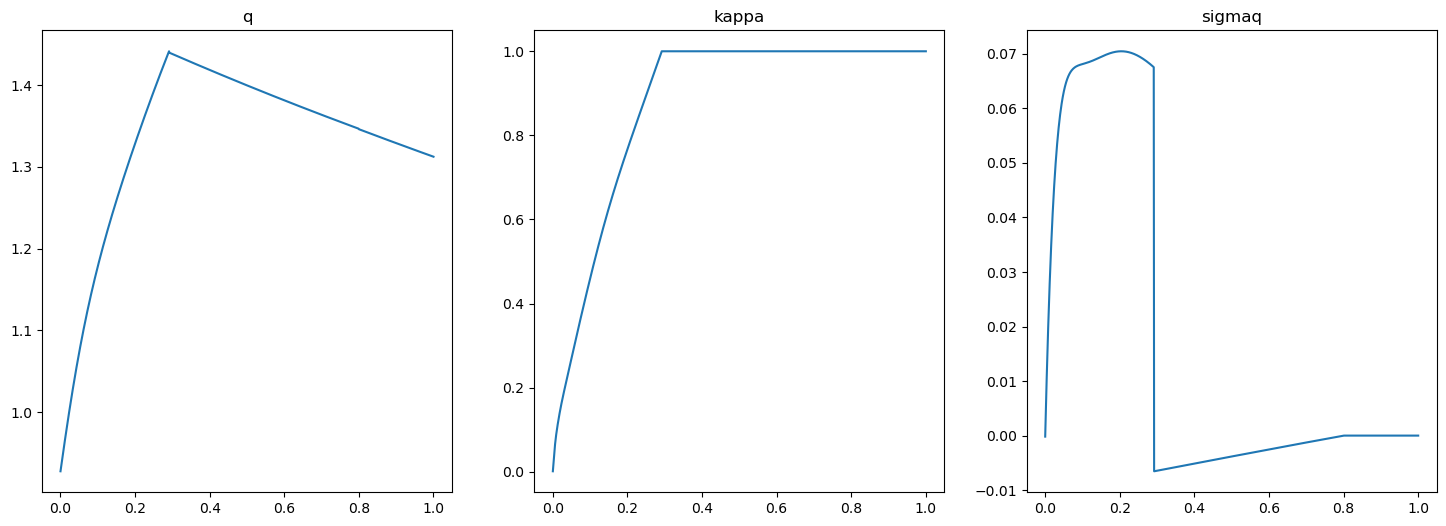

In [98]:
N = 1001
eta = torch.linspace(0, 1, N, device='cuda').reshape(-1, 1)
q_nn_unconstrain = pde_model_unconstrain.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1)
kappa_nn_unconstrain = pde_model_unconstrain.endog_vars["kappa"](eta).detach().cpu().numpy().reshape(-1)
sigmaq_nn_unconstrain = pde_model_unconstrain.endog_vars["sigmaq"](eta).detach().cpu().numpy().reshape(-1)

q_nn_short_sale_constrain = pde_model_short_constrain.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1)
sigmaq_nn_short_sale_constrain = pde_model_short_constrain.endog_vars["sigmaq"](eta).detach().cpu().numpy().reshape(-1)

kappa_lt_1 = (kappa_nn_unconstrain<1)
kappa_geq_1 = (kappa_nn_unconstrain>=1)
q_nn_no_leverage_constrain = q_nn_unconstrain*(kappa_lt_1) + q_nn_short_sale_constrain*(kappa_geq_1)
kappa_nn_no_leverage_constrain = kappa_nn_unconstrain*(kappa_lt_1) + 1*(kappa_geq_1)
sigmaq_nn_no_leverage_constrain = sigmaq_nn_unconstrain*(kappa_lt_1) + sigmaq_nn_short_sale_constrain*(kappa_geq_1)

eta = eta.cpu().numpy().reshape(-1)
eta_lt_alpha = (eta<alpha)
eta_geq_alpha = (eta>=alpha)
q_high_eta = (ae*phi + 1)/(phi*(eta*rhoe+(1-eta)*rhoh) + 1)
kappa_high_eta = 1
sigmaq_high_eta = 0

q_nn_no_leverage_constrain = q_nn_no_leverage_constrain*(eta_lt_alpha) + q_high_eta*(eta_geq_alpha)
kappa_nn_no_leverage_constrain = kappa_nn_no_leverage_constrain*(eta_lt_alpha) + kappa_high_eta*(eta_geq_alpha)
sigmaq_nn_no_leverage_constrain = sigmaq_nn_no_leverage_constrain*(eta_lt_alpha) + sigmaq_high_eta*(eta_geq_alpha)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(eta, q_nn_no_leverage_constrain, label="q")
ax[0].title.set_text("q")
ax[1].plot(eta, kappa_nn_no_leverage_constrain, label="kappa")
ax[1].title.set_text("kappa")
ax[2].plot(eta, sigmaq_nn_no_leverage_constrain, label="sigmaq")
ax[2].title.set_text("sigmaq")
plt.show()


#### Region 4: Leverage constraint

Note that we have skin in the game constraint $\chi \geq \alpha \kappa$ and leverage constraint $\chi \leq \ell \kappa+ \eta$. If $\alpha \kappa>\ell \kappa+ \eta$. It means the leverage constraint is now activated. 

The below code firstly check where the leverage constraint is activated, i.e., where we have $\alpha \kappa>\ell \kappa+ \eta$. And then In the solve the below ODE system:
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\chi - \eta) (\sigma + \sigma^q) - \sigma^q q = 0
\end{cases}
$$
where $\eta$ is the state variable, $(q, \sigma^q)$ are functions of $\eta$. We parameterize by Neural Network (NN) $(q, \sigma^q)$ where $\eta$ is the input. $\eta$ only ranges from the region that the leverage constraint is activated.

Note that $\kappa=\eta/(\alpha-\ell)$ becomes a variable, not a parameter. We need to use `add_equation(r"$\kappa = \eta/(\alpha-\ell)$")`

In [99]:
leverage_constrained_index = ell*kappa_nn_no_leverage_constrain + eta.reshape(-1) < alpha*kappa_nn_no_leverage_constrain
eta_leverage_constrained_min = eta[leverage_constrained_index].min()
eta_leverage_constrained_max = eta[leverage_constrained_index].max()
eta_leverage_constrained_count = leverage_constrained_index.sum()

batch_size = int(eta_leverage_constrained_count)
set_seeds(0)
pde_model_leverage_constrain = PDEModel(name = "Contrasting_Financial_Frictions", 
                                 latex_var_mapping=latex_var_mapping, 
                                 config={"sampling_method": SamplingMethod.FixedGrid, 
                                         "batch_size": batch_size,
                                         "num_epochs": 2000,
                                         "optimizer_type": OptimizerType.Adam})
pde_model_leverage_constrain.set_state(["eta"], {"eta": [eta_leverage_constrained_min, eta_leverage_constrained_max]})  
pde_model_leverage_constrain.add_endogs(names = ["q", "sigmaq"], 
                                 configs={"q": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "sigmaq": {"positive": False, "activation_type": ActivationType.SiLU}})
pde_model_leverage_constrain.add_params(params)

pde_model_leverage_constrain.add_endog_equation(r"$\kappa*a^e + (1 - \kappa)*a^h - \iota - q * ( \eta *\rho^e + (1 - \eta) *\rho^h ) = 0$", weight=batch_size) 
pde_model_leverage_constrain.add_endog_equation(r"$\frac{\partial q}{\partial \eta}* (\chi - \eta) *(\sigma + \sigma^q) - \sigma^q *q = 0$", weight=batch_size)

pde_model_leverage_constrain.add_equation(r"$\iota = \frac{1}{\phi} * (q - 1)$")
pde_model_leverage_constrain.add_equation(r"$\kappa = \eta/(\alpha-\ell)$")
pde_model_leverage_constrain.add_equation(r"$\chi = \alpha*\kappa$")
pde_model_leverage_constrain.train_model("./models/05", "05.pt", True)
pde_model_leverage_constrain.load_model(torch.load("./models/05/05.pt"))
pde_model_leverage_constrain.eval_model(True)

====================================Training====================================


Total loss: 0.0000: 100%|██████████| 2000/2000 [00:31<00:00, 63.33it/s]

training finished, total time :: 31.582991361618042
Best model saved to ./models/05/05_best.pt if valid
Model saved to ./models/05/05.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
total_loss: 0.0000


OrderedDict([('endogeq_1',
              tensor(3.4426e-08, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('endogeq_2',
              tensor(1.9356e-08, device='cuda:0', grad_fn=<MeanBackward0>)),
             ('total_loss',
              tensor(9.4119e-06, device='cuda:0', grad_fn=<AddBackward0>))])

The below code combines the 4 regions together.

In [100]:
N = 1001
eta = torch.linspace(0, 1, N, device='cuda').reshape(-1, 1)
q_nn_leverage_constrain = pde_model_leverage_constrain.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1)
kappa_nn_leverage_constrain = np.zeros(N)
kappa_nn_leverage_constrain[leverage_constrained_index] = pde_model_leverage_constrain.variable_val_dict["kappa"].detach().cpu().numpy().reshape(-1)
sigmaq_nn_leverage_constrain = pde_model_leverage_constrain.endog_vars["sigmaq"](eta).detach().cpu().numpy().reshape(-1)

eta = eta.cpu().numpy().reshape(-1)
q_nn = q_nn_no_leverage_constrain*(~leverage_constrained_index) + q_nn_leverage_constrain*(leverage_constrained_index)
kappa_nn = kappa_nn_no_leverage_constrain*(~leverage_constrained_index) + kappa_nn_leverage_constrain*(leverage_constrained_index)
sigmaq_nn = sigmaq_nn_no_leverage_constrain*(~leverage_constrained_index) + sigmaq_nn_leverage_constrain*(leverage_constrained_index)

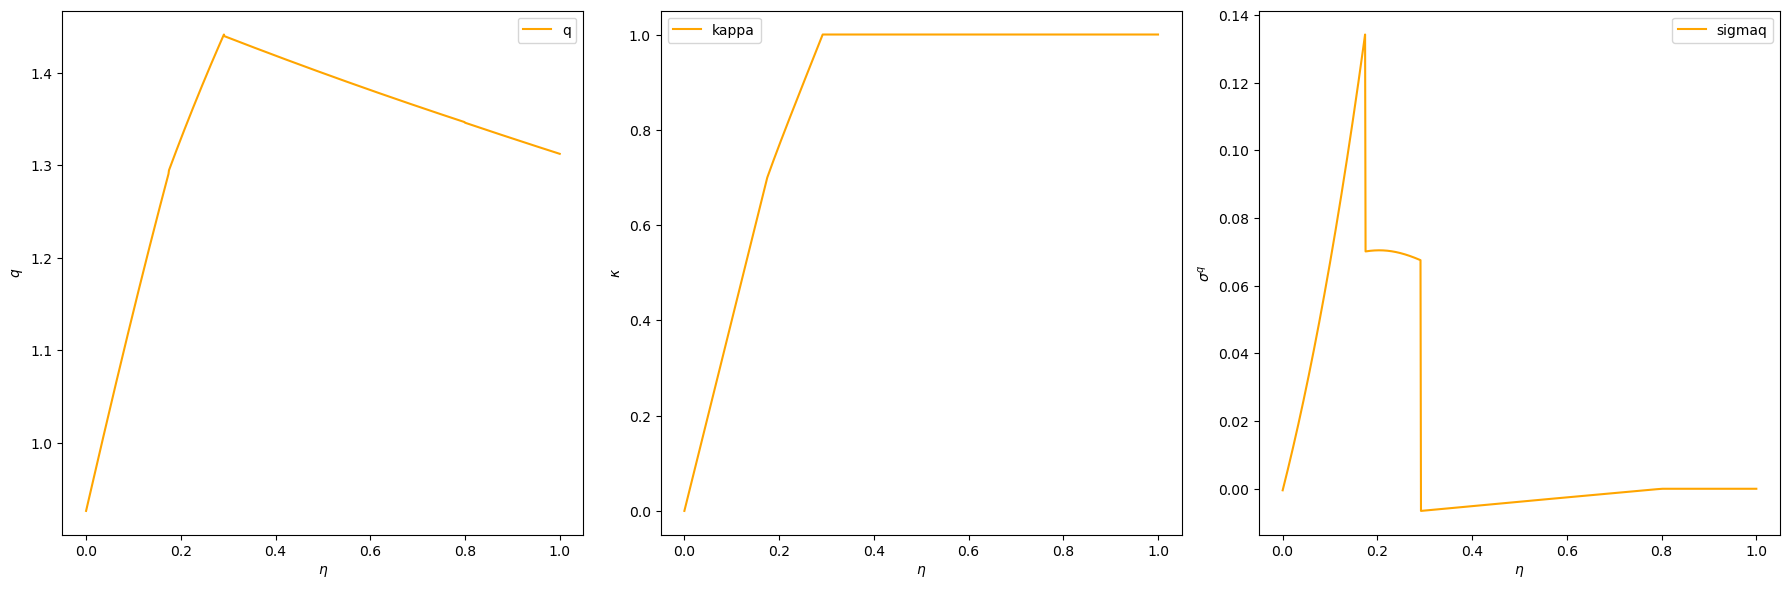

In [101]:
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q_nn, label='q', color='orange')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa_nn, label='kappa', color='orange')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq_nn, label='sigmaq', color='orange')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()

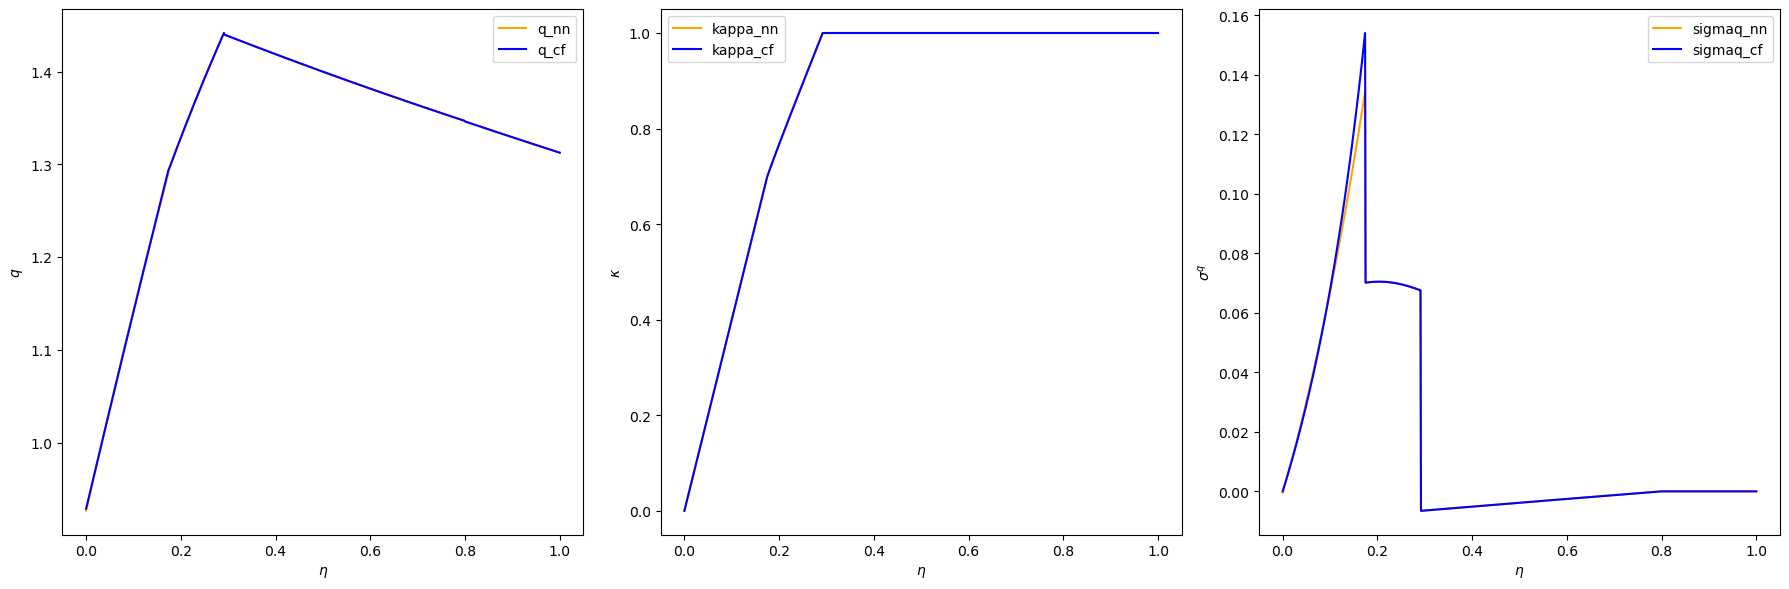

In [102]:
# below is a closed form solution for region 4
eta_leverage_constrain = eta[leverage_constrained_index]
q_cf_leverage_constrain = (eta_leverage_constrain/(alpha-ell)*ae + (1-eta_leverage_constrain/(alpha-ell))*ah + 1/phi)/(eta_leverage_constrain*rhoe + (1-eta_leverage_constrain)*rhoh + 1/phi)
qp_leverage_constrain = ((ae-ah)/(alpha-ell) - q_cf_leverage_constrain*(rhoe-rhoh))/(eta_leverage_constrain*rhoe + (1-eta_leverage_constrain)*rhoh + 1/phi)
kappa_cf_leverage_constrain = eta_leverage_constrain/(alpha-ell)
sigmaq_cf_leverage_constrain = sigma/(1 - qp_leverage_constrain/q_cf_leverage_constrain*(alpha*kappa_cf_leverage_constrain - eta_leverage_constrain)) - sigma

q_cf = q_nn.copy()
q_cf[leverage_constrained_index] = q_cf_leverage_constrain
kappa_cf = kappa_nn.copy()
kappa_cf[leverage_constrained_index] = kappa_cf_leverage_constrain
sigmaq_cf = sigmaq_nn.copy()
sigmaq_cf[leverage_constrained_index] = sigmaq_cf_leverage_constrain

fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q_nn, label='q_nn', color='orange')
ax[0].plot(eta, q_cf, label='q_cf', color='blue')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa_nn, label='kappa_nn', color='orange')
ax[1].plot(eta, kappa_cf, label='kappa_cf', color='blue')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq_nn, label='sigmaq_nn', color='orange')
ax[2].plot(eta, sigmaq_cf, label='sigmaq_cf', color='blue')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()


## Newton Method

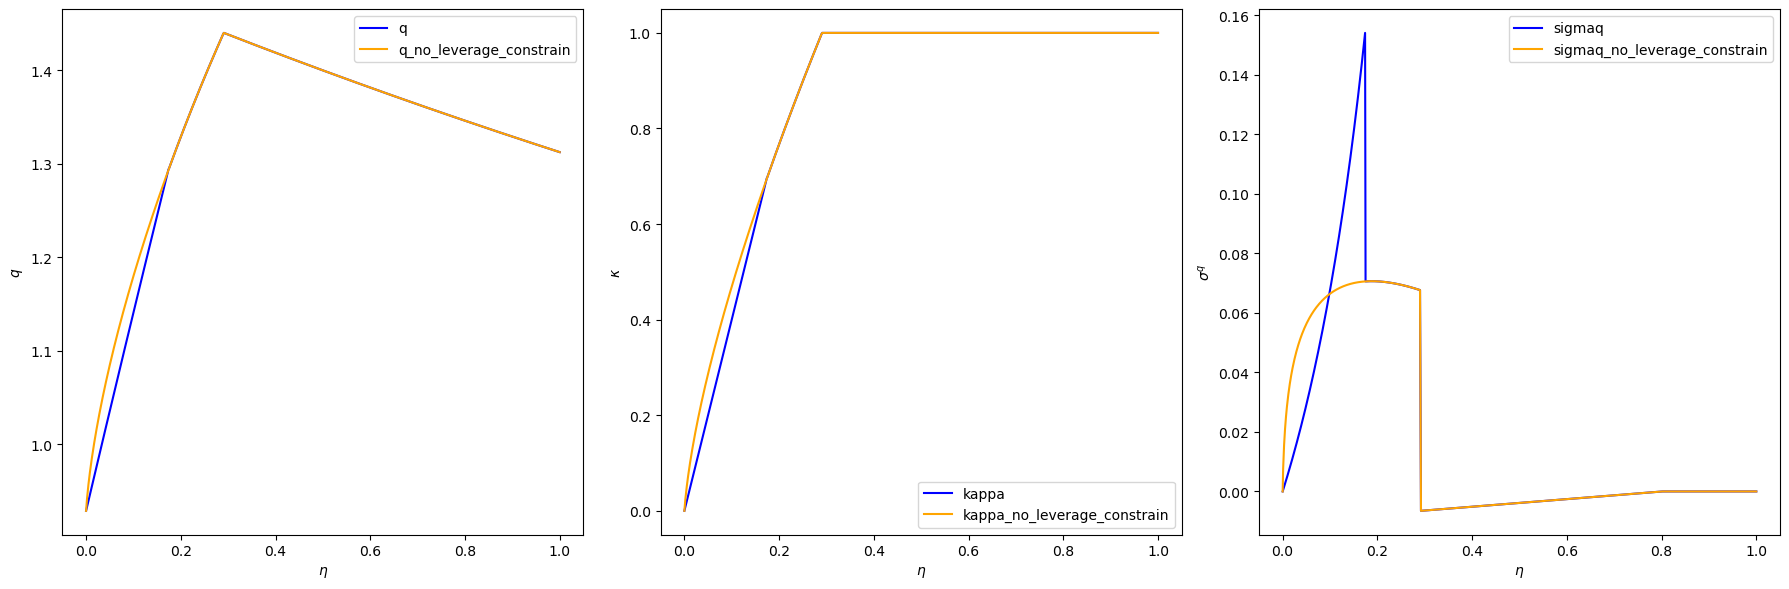

In [103]:
N = 1001
eta = np.linspace(0, 1, N)
eta_lt_alpha = eta[eta<alpha].copy()
h = eta[1]-eta[0]
globals().update(params) # unpack parameters
q_eta0=(phi*ah+1)/(phi*rhoh+1)
q_eta_alpha=(phi* ae + 1)/(phi*(eta*rhoe+(1-eta)*rhoh)+1)

def F(q, kappa, sigmaq, eta, q0):
    return np.array([[kappa*ae + (1-kappa)*ah - 1/phi*(q-1) -q*(eta*rhoe+(1-eta)*rhoh)],
                    [(q-q0)/h*(alpha*kappa-eta)*(sigma+sigmaq)-sigmaq*q],
                    [(ae-ah) - alpha*q*(alpha*kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)**2]])

def DF(q, kappa, sigmaq, eta, q0):
    return np.array([[-1/phi-(eta*rhoe+(1-eta)*rhoh),               ae-ah,                               0                                   ],
                    [1/h*(alpha*kappa-eta)*(sigma+sigmaq)-sigmaq,         (q-q0)/h*(sigma+sigmaq)*alpha,             (q-q0)/h*(alpha*kappa-eta)-q   ],
                    [-alpha*(alpha*kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)**2,  -alpha**2*q*(sigma+sigmaq)**2/((1-eta)*eta),  -2*alpha*q*(alpha*kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)]])
    
def Newton(z_guess, eta):
    q0 = z_guess[0,0]
    z = z_guess
    while True:
        z_new = z - np.linalg.inv(DF(z[0,0], z[1,0], z[2,0], eta, q0))@F(z[0,0], z[1,0], z[2,0], eta, q0)
        if (np.abs(z_new - z)< 1e-8).all():
            break
        else:
            z = z_new
    return z_new

def F_fix_kappa(q, sigmaq, eta, q0, kappa):
    return np.array([[kappa*ae + (1-kappa)*ah - 1/phi*(q-1) -q*(eta*rhoe+(1-eta)*rhoh)],
                    [(q-q0)/h*(alpha*kappa-eta)*(sigma+sigmaq)-sigmaq*q]])

def DF_fix_kappa(q, sigmaq, eta, q0, kappa):
    return np.array([[-1/phi-(eta*rhoe+(1-eta)*rhoh),    0                 ],
                    [1/h*(alpha*kappa-eta)*(sigma+sigmaq)-sigmaq,  (q-q0)/h*(alpha*kappa-eta)-q]])
    
def Newton_fix_kappa(z_guess, eta, kappa=1):
    q0 = z_guess[0,0]
    z = z_guess
    while True:
        z_new = z - np.linalg.pinv(DF_fix_kappa(z[0,0], z[1,0], eta, q0, kappa))@F_fix_kappa(z[0,0], z[1,0], eta, q0, kappa)
        if (np.abs(z_new - z)< 1e-8).all():
            break
        else:
            z = z_new
    return z_new


z_list = np.zeros((3, len(eta)))
z_list[:,[0]] = np.array([[q_eta0],[0],[0]])

# for eta<alpha and kappa<1
for i in range(1, len(eta_lt_alpha)):
    z_guess = z_list[:,[i-1]]
    z_list[:,[i]] = Newton(z_guess, eta[i])
    if z_list[[1],[i]]>1:
        break
# for eta<alpha and kappa=1
for j in range(i, len(eta_lt_alpha)):
    z_guess = z_list[[[0],[2]],[j-1]]
    z_list[[[0],[2]],[j]] = Newton_fix_kappa(z_guess, eta[j])
    z_list[1,[j]] = 1

# for eta>=alpha
z_list[0,j+1:] = q_eta_alpha[j+1:]
z_list[1,j+1:] = 1
z_list[2,j+1:] = 0

q_no_leverage_constrain = z_list[0,:].copy()
kappa_no_leverage_constrain = z_list[1,:].copy()
sigmaq_no_leverage_constrain = z_list[2,:].copy()
iota_no_leverage_constrain = 1/phi*(q_no_leverage_constrain-1)

for k in range(1, len(eta_leverage_constrain)):
    z_guess = z_list[[[0],[2]],[k-1]]
    z_list[[[0],[2]],[k]] = Newton_fix_kappa(z_guess, eta[k], kappa= eta[k]/(alpha-ell))
    z_list[1,[k]] = eta[k]/(alpha-ell)

q = z_list[0,:].copy()
kappa = z_list[1,:].copy()
sigmaq = z_list[2,:].copy()
iota = 1/phi*(q-1)

fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q, label='q', color='blue')
ax[0].plot(eta, q_no_leverage_constrain, label='q_no_leverage_constrain', color='orange')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa, label='kappa', color='blue')
ax[1].plot(eta, kappa_no_leverage_constrain, label='kappa_no_leverage_constrain', color='orange')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq, label='sigmaq', color='blue')
ax[2].plot(eta, sigmaq_no_leverage_constrain, label='sigmaq_no_leverage_constrain', color='orange')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()

## Comparison between neural network and Newton method

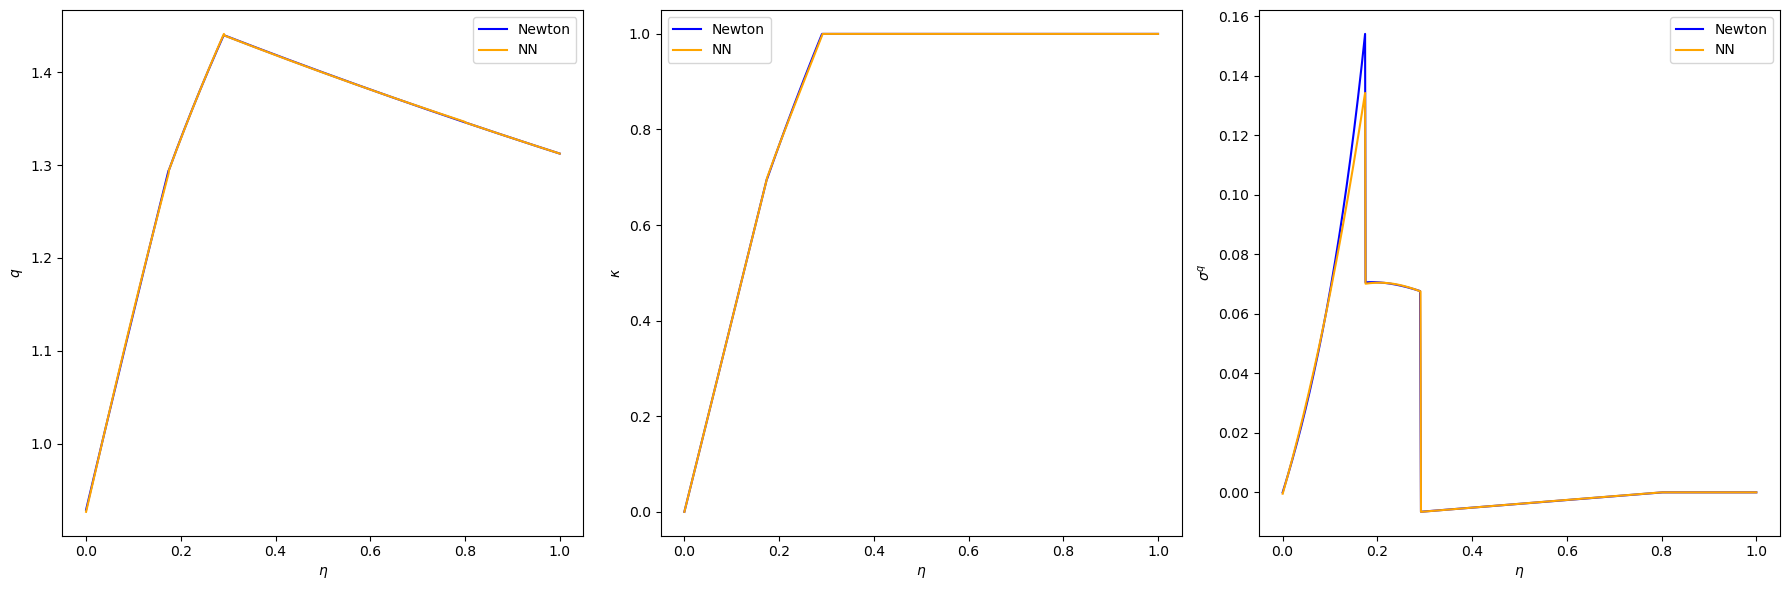

In [104]:
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q, label='Newton', color='blue')
ax[0].plot(eta, q_nn, label='NN', color='orange')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa, label='Newton', color='blue')
ax[1].plot(eta, kappa_nn, label='NN', color='orange')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq, label='Newton', color='blue')
ax[2].plot(eta, sigmaq_nn, label='NN', color='orange')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()